In [8]:
import numpy as np
from statsmodels.multivariate.factor import Factor
from tqdm import tqdm
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
def CFM_fill(cfm): # fill the whole coefficient matrix from diagnal parameters
    n = len(cfm) + 1
    CFM = np.ones((n,n))
    for i in range(n-1):
        for j in range(n-i-1):
            CFM[i][i+j+1] = cfm[i][j]
            CFM[i+j+1][i] = cfm[i][j]
    return CFM
def acc_var(lm, val): # input loading matrix and eigenvalues, give accumulate variance contribution
    variance_explained = np.sum(lm**2, axis=0)/sum(val)
    # Calculate the total variance
    total_variance = np.sum(variance_explained)
    # Calculate the variance contribution rate for each factor
    variance_contribution_rate = np.cumsum(variance_explained)
    print("\nVariance Contribution Rate for Each Factor:")
    print((variance_contribution_rate).round(3))
#     print("Total Variance Contribution Rate: ", end = '')
#     print((total_variance*100).round(3), end = '%\n')
def norvar(x): # normalize variables to normal distribution
    x = x - np.mean(x)
    var = np.var(x)**0.5
    return x/var
def norm(m): # normalize variable matrix
    return [norvar(i) for i in m]

def covlize(m): # make covariance to be diagnal with 1
    return [i*((len(i)-1)/len(i))**0.5 for i in m]
def randeig(n):
    np.random
def datasimulator(cfm1, n):
    # input eigenvalue, eigenvector(of the first row of a correlation coefficient matrix), and sample size n
    x = np.random.normal(loc=0.0, scale=1.0, size=(len(cfm1) + 1, n))
    var = norm(x)
    # let variables be othogonal
    for i in range(len(cfm1)):
        j = i + 1
        var[j] = var[j] - var[i] * np.corrcoef(var[i],var[j])[0][1]
        var[j] = norvar(var[j])
        var[j] = var[j] * np.sqrt(1 - cfm1[i]**2) + var[i] * cfm1[i]
    var = np.array(var)
    return var # return normal distributed data following given correlation coefficient matrix
def heywood(cfm1, n):# heywood case with n samples
    k = len(cfm1) + 1
    hw = np.zeros(k)
    simdata = datasimulator(cfm1, n)
    CFM = np.corrcoef(simdata)
#     print(CFM, simdata)
    for i in range(k):
        fa = Factor(endog = simdata.T, n_factor = i + 1, method = 'ml', smc = True)
        fa_result = fa.fit()
        # Get the factor loading matrix
        loading_matrix = fa_result.loadings
        res = CFM - loading_matrix @ loading_matrix.T
        if min(np.diagonal(res)) < 0:
            hw[i] = 1
    return hw

In [2]:
h = 1
k = 7
cfm1 = np.random.rand(h, k-1)*2-1
print(cfm1)
np.corrcoef(datasimulator(cfm1[0], 10))

[[-0.36252841 -0.50251451 -0.98878099  0.99856291 -0.92704933 -0.88585083]]


array([[ 1.        ,  0.23169561,  0.49316574, -0.10436146, -0.03051803,
         0.0583154 ,  0.04774869],
       [ 0.23169561,  1.        , -0.2088111 , -0.01131811, -0.12456719,
        -0.46210426,  0.39755996],
       [ 0.49316574, -0.2088111 ,  1.        , -0.15342739, -0.12308491,
         0.38804903, -0.44243535],
       [-0.10436146, -0.01131811, -0.15342739,  1.        , -0.43352453,
         0.28368458,  0.25082421],
       [-0.03051803, -0.12456719, -0.12308491, -0.43352453,  1.        ,
         0.28871882,  0.39143134],
       [ 0.0583154 , -0.46210426,  0.38804903,  0.28368458,  0.28871882,
         1.        ,  0.13445717],
       [ 0.04774869,  0.39755996, -0.44243535,  0.25082421,  0.39143134,
         0.13445717,  1.        ]])

In [34]:
hl = [100, 100, 100, 100]
nl = [25, 50, 25, 50]
kl = [10, 10, 20, 20]
# hl = [100, 100, 100, 100]
# nl = [30, 60, 30, 60]
# kl = [10, 10, 20, 20]

In [18]:
for i in range(len(hl)):
    h = hl[i]
    n = nl[i]
    k = kl[i]
    cfm1 = np.random.rand(h, k-1)*2-1 # h rows (first of row correlation matrix)
    hey_h = [0 for i in range(h)] # factorwise heywood case'
    for i in tqdm(range(h), position=0):
        hey_h[i] = heywood(cfm1[i], n)
    np.savetxt('heywood'+str(h)+'×'+str(n)+'×'+str(k)+'.txt', np.array(hey_h), fmt='%f',delimiter=' ')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:31<00:00,  6.91s/it]


h = 100 , n = 60 , k = 20


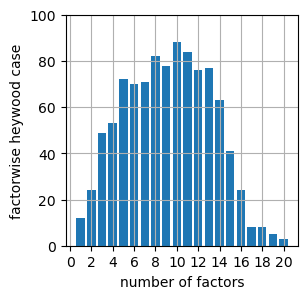

samplewise heywood case ratio: 100.0%
total heywood case ratio: 49.4%


In [33]:
index = 3
h = 100
n = nl[index]
k = kl[index]
hw = np.loadtxt('heywood'+str(h)+'×'+str(n)+'×'+str(k)+'.txt',delimiter=' ')
hc = 0 # samplewise heywood case
for i in hw:
    if max(i) == 1:
        hc += 1
hp = np.sum(hw, axis = 0) # total heywood case 
plt.figure (figsize= (3, 3)) 
plt.bar(range(1, len(hp)+1), hp)
plt.ylim(0, h)
ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(kl[index]/10))
plt.grid()
plt.xlabel('number of factors')
plt.ylabel('factorwise heywood case')
plt.savefig('heywood'+str(h)+'×'+str(n)+'×'+str(k)+'.png',dpi=500,bbox_inches = 'tight')
print('h =', h, ', n =', n, ', k =', k)
plt.show()
print('samplewise heywood case ratio: %.1f'%(hc/h*100), end = '%\n')
print('total heywood case ratio: %.1f'%(sum(hp)/h/k*100), end = '%\n')